In [1]:
from tqdm import tqdm

from lib import mutation, plot

from lib.dataloader import load_data
from lib.task import make_tasks

from lib.solver.anneal_solver import AnnealSolver
from lib.temperature import exponential

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = load_data('../all')

big_data = sorted([df for df in data.values() if len(df['trace']) >= 200], key=lambda df: len(df['trace']))
big_tasks = make_tasks(big_data)
top10 = big_tasks[-10:]

100%|██████████| 52967/52967 [01:48<00:00, 487.76it/s]


In [5]:
solver = AnnealSolver(
    mutation=mutation.concat(
        mutation.conditional(
            mutation.AssignRandomIdleCandidateToRandomRouteTillImpossible,
            epoch_predicat=lambda epoch: epoch == 0
        ),
        mutation.conditional(
            mutation.MakeRoomForRandomCandidate,
            epoch_predicat=lambda epoch: epoch != 0 and epoch % 500 == 0
        ),
        mutation.TryRecallRandomBusyCandidate,
        mutation.AssignRandomIdleCandidateToRandomRouteIfPossible,
        mutation.TryAssignRandomIdleCandidateToRandomRoute,
        mutation.TryAssignRandomIdleCandidateToRandomRoute,
    ),
    epoches=10_000,
    temp=exponential(20000, 1.001),
    beamsearch_size=2,
)

In [6]:
solver.solve_all(*top10, retries=10, tqdm=tqdm)

100%|██████████| 100/100 [12:53<00:00,  7.73s/it]


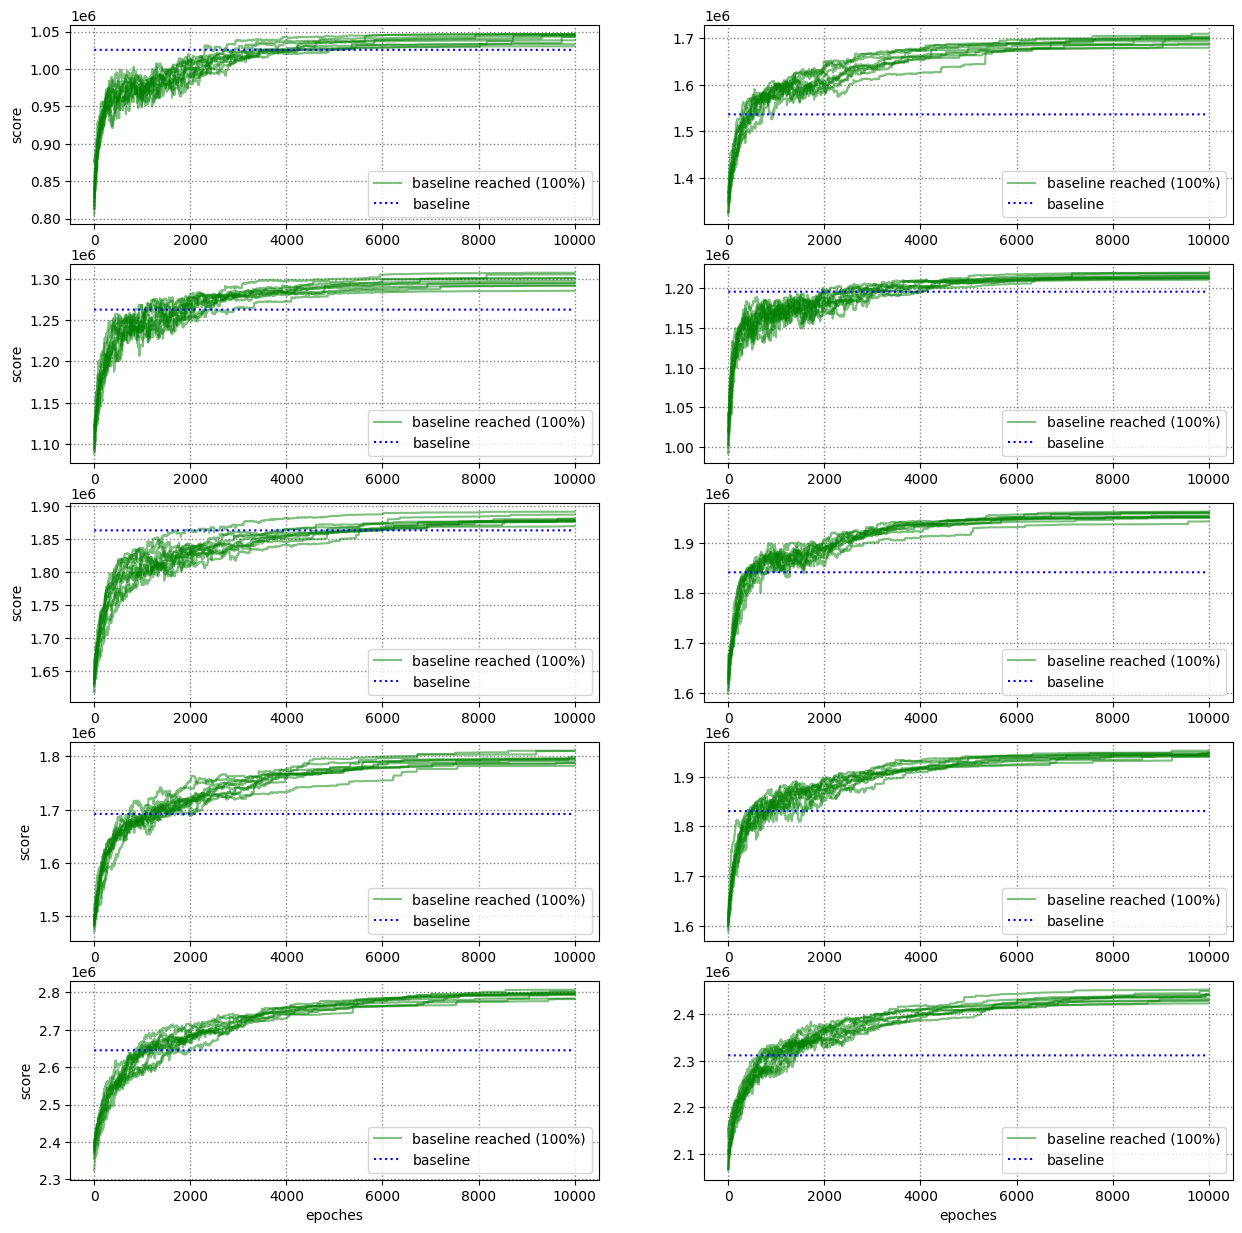

In [7]:
plot.solve_history(*top10, exclude_init=True)

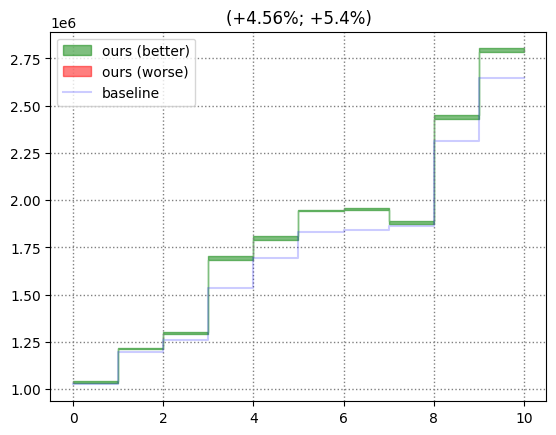

In [8]:
plot.total_diff_interval(*top10, confidence_interval=(0.1, 0.9))

In [9]:
solver.solve_all(*big_tasks, tqdm=tqdm)

100%|██████████| 997/997 [1:02:08<00:00,  3.74s/it]


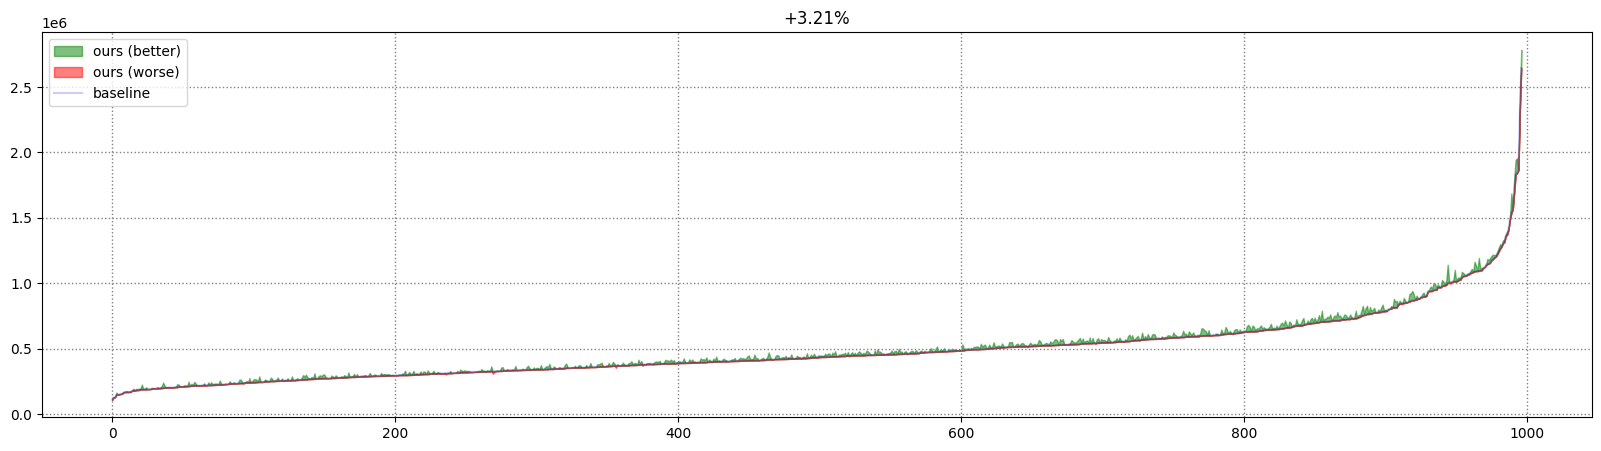

In [10]:
plot.total_diff(*big_tasks, last_n=1, figsize=(20, 5))

In [12]:
%prun -s cumulative solver.solve(big_tasks[0])

         14640445 function calls (13137913 primitive calls) in 4.928 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.944    4.944 {built-in method builtins.exec}
        1    0.007    0.007    4.944    4.944 <string>:1(<module>)
        1    0.006    0.006    4.937    4.937 anneal_solver.py:24(solve)
        1    0.032    0.032    4.924    4.924 anneal.py:86(anneal_beamsearch)
    14927    0.022    0.000    4.636    0.000 anneal.py:100(<listcomp>)
    29854    0.046    0.000    4.615    0.000 anneal.py:30(iterate_anneal)
    29854    0.010    0.000    4.407    0.000 anneal.py:100(<lambda>)
    29854    0.022    0.000    4.397    0.000 anneal_solver.py:28(mutate)
    29854    0.019    0.000    4.295    0.000 mutation.py:100(impl)
    29854    0.053    0.000    4.272    0.000 mutation.py:101(<listcomp>)
    30001    0.206    0.000    2.333    0.000 mutation.py:24(AssignRandomIdleCandidateToR